In [32]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import kornia as tgm

## Input Parameters


In [25]:
input_dir = 'data'
src_name = 'img1.ppm'  # source image file
dst_name = 'img2.ppm'  # destinatipn image file
learning_rate = 1e-3
num_iterations = 400  
log_interval = 50  # print log every 200 iterations
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cuda


In [27]:
def load_image(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor                                      
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)

    # load image with OpenCV                                                                         
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)

    # convert image to torch tensor                                                                  
    tensor = tgm.utils.image_to_tensor(img).float() / 255.
    tensor = tensor.view(1, *tensor.shape)  # 1xCxHxW
    return tensor, img

### Container to hold the homography as a trainable parameter

In [ ]:
class MyHomography(nn.Module):
    def __init__(self):
        super(MyHomography, self).__init__()
        self.homo = nn.Parameter(torch.Tensor(3, 3))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.eye_(self.homo)

    def forward(self):
        return torch.unsqueeze(self.homo, dim=0)  # 1x3x3  

### Read images and convert  to tensor

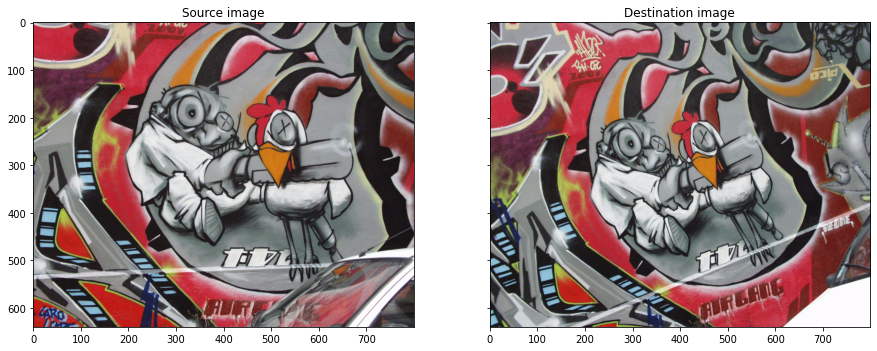

In [28]:
%matplotlib inline
img_src_t, img_src = load_image(os.path.join(input_dir, src_name))
img_dst_t, img_dst = load_image(os.path.join(input_dir, dst_name))
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.imshow(img_src[:,:,::-1])
ax1.set_title('Source image')
ax2.imshow(img_dst[:,:,::-1])
ax2.set_title('Destination image')
plt.show()

### Initialize the warper and the homography

In [29]:
height, width = img_src_t.shape[-2:]
warper = tgm.HomographyWarper(height, width) #todo comment
dst_homo_src = MyHomography().to(device)
optimizer = optim.Adam(dst_homo_src.parameters(), lr=learning_rate)
# send data to device
img_src_t, img_dst_t = img_src_t.to(device), img_dst_t.to(device)

In [30]:
def draw_rectangle(image, dst_homo_src):
    height, width = image.shape[:2]
    pts_src = torch.FloatTensor([[
        [-1, -1],  # top-left
        [1, -1],  # bottom-left
        [1, 1],  # bottom-right
        [-1, 1],  # top-right
    ]]).to(dst_homo_src.device)
    # transform points
    pts_dst = tgm.transform_points(torch.inverse(dst_homo_src), pts_src)

    def compute_factor(size):
        return 1.0 * size / 2

    def convert_coordinates_to_pixel(coordinates, factor):
        return factor * (coordinates + 1.0)
    # compute convertion factor
    x_factor = compute_factor(width - 1)
    y_factor = compute_factor(height - 1)
    pts_dst = pts_dst.cpu().squeeze().detach().numpy()
    pts_dst[..., 0] = convert_coordinates_to_pixel(
        pts_dst[..., 0], x_factor)
    pts_dst[..., 1] = convert_coordinates_to_pixel(
        pts_dst[..., 1], y_factor)

    # do the actual drawing
    image = np.ascontiguousarray(image)
    for i in range(4):
        pt_i = pts_dst[i % 4]
        pt_ii = pts_dst[(i + 1) % 4]
        pt_i = [int(round(x)) for x in pt_i]
        pt_ii = [int(round(x)) for x in pt_ii]
        image = cv2.line(image, pt_i, pt_ii, (255, 0, 0), 3)
        return image

### Main optimization loop

This is the loss function to minimize the photometric error:
 $ L = \sum |I_{ref} - \omega(I_{dst}, H_{ref}^{dst}))|$

Train iteration: 0/400	Loss: 0.274363
(640, 800, 3)


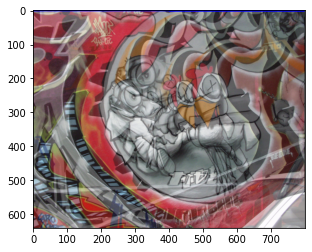

Train iteration: 50/400	Loss: 0.259754
(640, 800, 3)


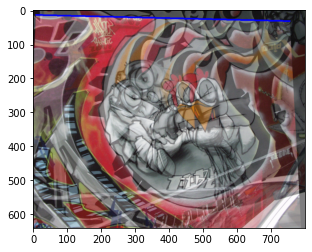

Train iteration: 100/400	Loss: 0.229281
(640, 800, 3)


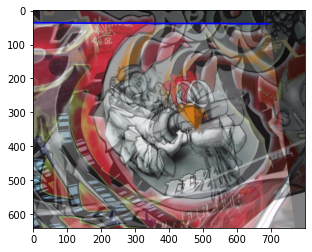

Train iteration: 150/400	Loss: 0.201827
(640, 800, 3)


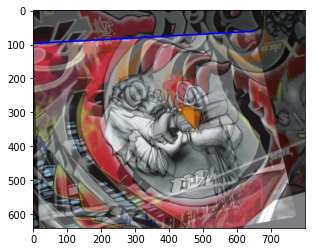

Train iteration: 200/400	Loss: 0.185681
(640, 800, 3)


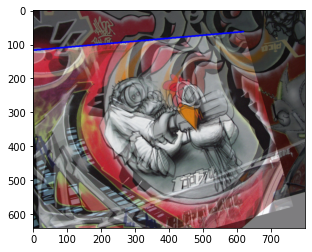

Train iteration: 250/400	Loss: 0.100843
(640, 800, 3)


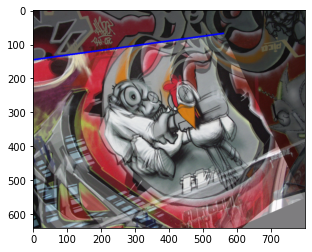

Train iteration: 300/400	Loss: 0.0178076
(640, 800, 3)


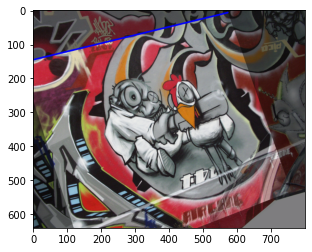

Train iteration: 350/400	Loss: 0.0159242
(640, 800, 3)


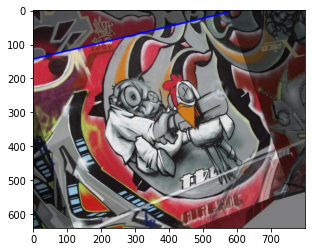

Train iteration: 399/400	Loss: 0.0159183
(640, 800, 3)


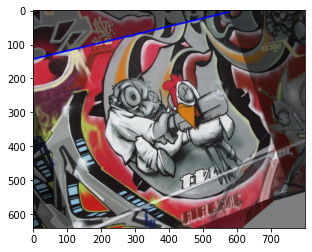

In [31]:
for iter_idx in range(num_iterations):
    # warp the reference image to the destiny with current homography
    img_src_to_dst = warper(img_src_t, dst_homo_src())

    # compute the photometric loss
    loss = F.l1_loss(img_src_to_dst, img_dst_t, reduction='none')

    # propagate the error just for a fixed window
    w_size = 100  # window size
    h_2, w_2 = height // 2, width // 2
    loss = loss[..., h_2 - w_size:h_2 + w_size, w_2 - w_size:w_2 + w_size]
    loss = torch.mean(loss)

    # compute gradient and update optimizer parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Debug draw:
    if iter_idx % log_interval == 0 or iter_idx == num_iterations-1:
        print('Train iteration: {}/{}\tLoss: {:.6}'.format(
        iter_idx, num_iterations, loss.item()))
        # merge warped and target image for visualization
        img_src_to_dst = warper(img_src_t, dst_homo_src())
        img_vis = 255. * 0.5 * (img_src_to_dst + img_dst_t)
        img_vis_np = tgm.utils.tensor_to_image(img_vis[0, ...])
        image_draw = draw_rectangle(img_vis_np, dst_homo_src())
        print (image_draw.shape)
        plt.imshow(image_draw.astype('uint')[:,:,::-1])
        plt.show()